In [1]:
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np
from sqlite3 import connect

The data covers video games sales from 1971 to current. Some of the data is missing or not available so we are taking the final numbers with a grain of salt. 
<br>
This is a basic notebook. Please provide feedback if inclined. 
<br>
data source: https://www.kaggle.com/datasets/asaniczka/video-game-sales-2024
<br>
contact me here: https://github.com/dmorton714/v_game.git
<br> 
or here: danny.morton714@gmail.com

| Functions | Description | How its used |
| -- | -- | -- |
| check_missing_items | identify missing items in a DataFrame column compared to a list | Runs automatically |
| assign_console_mfg | assigns categories to rows based on predefined console categories| Runs automatically  |
| check_missing_items <br> assign_console_mfg | Used together to checks for missing items, prints a message if any, <br> assigns 'console_mfg' values, and displays the DataFrame with the new column| Runs automatically |
| filter_and_group_by_year | generates DataFrames for years 1971 - 2023 | sales_xxxx  |
| single_graph | This plots a single console and looks at its game sales for a picked time line | single_graph((1990, 2024), 'N64') |
| stacked_graph  | This plots a several consoles and looks at its game sales for a picked time line  | stacked_graph((1980, 2024), 'PS3', 'PS4', 'PS2') |
| graph  |  This plots a several consoles and looks at its game sales for a picked time line | graph((1980, 2024), 'PS3', 'PS4', 'PS2') |

# Reading in the data and verifying its working

In [2]:
df = pd.read_csv('/kaggle/input/video-game-sales-2024/vgchartz-2024.csv')
df.head(1)

,img,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,last_update
0,/games/boxart/full_6510540AmericaFrontccc.jpg,Grand Theft Auto V,PS3,Action,Rockstar Games,Rockstar North,9.4,20.32,6.37,0.99,9.85,3.12,2013-09-17,NaN


# cleaning

- Converting release_date col to datetime
- Dropping the img and last_update cols
- Droppin the rows where the 'release_date' column has missing (NaN) values
- Fills cols 'critic_score', 'total_sales', 'na_sales', 'jp_sales', 'pal_sales', 'other_sales' with missing values to 0 

In [3]:
df['release_date'] = pd.to_datetime(df['release_date'])
df.drop(['img', 'last_update'], axis=1, inplace=True)
df = df.dropna(subset=['release_date'])
columns_to_fill_zero = ['critic_score', 'total_sales', 'na_sales', 'jp_sales', 'pal_sales', 'other_sales']
df[columns_to_fill_zero] = df[columns_to_fill_zero].fillna(0)

# Functions 

The code defines a function `check_missing_items` to identify missing items in a DataFrame column compared to a list. 
<br>
Another function, `assign_console_mfg`, assigns categories to rows based on predefined console categories. 
<br>
The code then checks for missing items, prints a message if any, assigns 'console_mfg' values, and displays the DataFrame with the new column.

In [4]:
def check_missing_items(all_items, df_column):
    all_items_lower = [item.lower().strip() for item in all_items]
    unique_values_lower = set(df_column.str.lower().str.strip().unique())
    return set(all_items_lower) - unique_values_lower

def assign_console_mfg(df):
    categories = {
        'nintendo': ['3DS', 'ds', 'Wii', 'WiiU', 'NS', 'GB', 'NES', 'SNES', 'GBC', 'N64'],
        'pc': ['Linux', 'OSX', 'PC', 'Arc', 'All'],
        'xbox': ['X360', 'XOne', 'Series'],
        'sony': ['PS', 'PS2', 'PS3', 'PS4', 'PS5', 'PSP', 'PSV', 'PSN'],
        'mobile': ['iOS', 'And'],
        'sega': ['GG', 'MSD', 'MS', 'GEN', 'SCD'],
        'atari': ['2600', '7800'],
        'commodore': ['amig', 'C64'],
        'other': ['Ouya', 'OR', 'ACPC', 'AST', 'ApII', 'PCE', 'ZXS', 'Lynx', 'NG', 'ZXS']
    }

    all_items = [item for sublist in categories.values() for item in sublist]

    missing_items = check_missing_items(all_items, df['console'])

    if missing_items:
        print(f"Missing items: {missing_items}")
    else:
        print("All items are covered.")

    conditions = [df['console'].isin(items) for items in categories.values()]
    values = list(categories.keys())

    df['console_mfg'] = np.select(conditions, values, default='unknown')


assign_console_mfg(df)

All items are covered.


Defines a function called `filter_and_group_by_year` 
- which takes a DataFrame (df) and a target year as input
 
- It filters the DataFrame to include only rows from the specified year

- Groups the data by 'release_date' and 'console'
 
- calculates the sum of 'total_sales' for each group
 
- Updates the 'release_date' column to show only the year.

- Then, groups the data again by the modified 'release_date' and 'console' columns

- Calculates the sum of 'total_sales' again 

- Returns the resulting DataFrame.

In the second part of the code
- there is a loop that iterates through years from 1971 to 2023
- In each iteration, it dynamically creates a DataFrame with a name like 'sales_1971', 'sales_1972', etc. 
- Then assigns the result of the function for that specific year to the newly created DataFrame variable.

This loop essentially generates DataFrames for years 1971 - 2023, 
<br>
each representing the sales data for a particular year, and assigns
<br>
them unique names using the 'sales_year' format.

In [5]:
def filter_and_group_by_year(df, target_year):
    df['release_date'] = pd.to_datetime(df['release_date'])
    df_filtered = df[df['release_date'].dt.year == target_year]
    result = df_filtered.groupby(['release_date', 'console'])['total_sales'].sum().reset_index()
    result['release_date'] = result['release_date'].dt.year  
    result = result.groupby(['release_date', 'console'])['total_sales'].sum().reset_index()
    return result

for year in range(1971, 2024):
    df_name = f"sales_{year}"
    globals()[df_name] = filter_and_group_by_year(df, year)

The function takes a date range and a console name, filters the data for that console within the specified range, computes the total video game sales and a trend curve, and then visualizes the results using a bar chart and a trend curve plot.

In [6]:
def single_graph(date_range, console):
    
    df['release_date'] = pd.to_datetime(df['release_date'])
    
    
    filtered_df = df[(df['release_date'].dt.year >= date_range[0]) & 
                     (df['release_date'].dt.year <= date_range[1]) & 
                     (df['console'] == console)]

    
    sales_by_year = filtered_df.groupby(filtered_df['release_date'].dt.year)['total_sales'].sum().reset_index()

    
    plt.figure(figsize=(10, 6))
    
    
    plt.bar(sales_by_year['release_date'], sales_by_year['total_sales'], label='Total Sales')
    
    # Trend curve
    x = sales_by_year['release_date']
    y = sales_by_year['total_sales']
    
    z = np.polyfit(x, y, 2)
    p = np.poly1d(z)

    # Clip values below 0
    trend_line = np.maximum(p(x), 0)  
    
    plt.plot(x, trend_line, 'r--', label='Trend Curve')
    
    plt.xlabel('Year')
    plt.ylabel('Total Sales')
    plt.title(f'Total Sales of {console} from {date_range[0]} to {date_range[1]}')
    
    plt.legend()
    
    plt.show()

The function takes several date ranges and a console names, filters the data for the consoles within the specified range, computes the total video game sales and a trend curve, and then visualizes the results using a bar chart and a trend curve plot.The bars are stacked so usage may not be the best for all plots. If effects are not desired use function `graph()` in its place.

In [7]:
def stacked_graph(date_range, *consoles):
    
    df['release_date'] = pd.to_datetime(df['release_date'])
    
    
    filtered_df = df[(df['release_date'].dt.year >= date_range[0]) & 
                     (df['release_date'].dt.year <= date_range[1]) & 
                     (df['console'].isin(consoles))]

    
    sales_by_year = filtered_df.groupby(['release_date', 'console'])['total_sales'].sum().reset_index()

    
    plt.figure(figsize=(12, 8))
    
    for console in consoles:
        console_data = sales_by_year[sales_by_year['console'] == console]
        x = console_data['release_date'].dt.year  
        y = console_data['total_sales']
        
        # Trend curve
        z = np.polyfit(x, y, 2)
        p = np.poly1d(z)
         # Clip values below 0
        trend_line = np.maximum(p(x), 0) 
        
        # Bar plot
        plt.bar(x, y, label=f'Total Sales - {console}')
        
        # Trend curve plot
        plt.plot(x, trend_line, '--', label=f'Trend Curve - {console}')

    plt.xlabel('Year')
    plt.ylabel('Total Sales')
    plt.title(f'Total Sales Comparison of Consoles from {date_range[0]} to {date_range[1]}')
    
    # Display legend
    plt.legend()
    
    plt.show()

The function takes several date ranges and a console names, filters the data for the consoles within the specified range, computes the total video game sales and a trend curve, and then visualizes the results using a bar chart and a trend curve plot.

In [8]:
def graph(date_range, *consoles):
   
    df['release_date'] = pd.to_datetime(df['release_date'])
    

    filtered_df = df[(df['release_date'].dt.year >= date_range[0]) & 
                     (df['release_date'].dt.year <= date_range[1]) & 
                     (df['console'].isin(consoles))]

    
    sales_by_year = filtered_df.groupby(['release_date', 'console'])['total_sales'].sum().reset_index()

    
    plt.figure(figsize=(12, 8))
    
    for i, console in enumerate(consoles):
        console_data = sales_by_year[sales_by_year['console'] == console]
        x = console_data['release_date'].dt.year  
        y = console_data['total_sales']
        
        # Trend curve
        z = np.polyfit(x, y, 2)
        p = np.poly1d(z)
        # Clip values below 0
        trend_line = np.maximum(p(x), 0)  
        
        cmap = plt.get_cmap('tab10')
        bar_color = cmap(i)
        darker_bar_color = tuple(c * 0.6 for c in bar_color)
        
        
        plt.bar(x + i * 0.3, y, width=0.3, color=bar_color, label=f'Total Sales - {console}')

        
        plt.plot(x, trend_line, '-', color=darker_bar_color, linewidth=2, label=f'Trend Curve - {console}', zorder=10)

    plt.xlabel('Year')
    plt.ylabel('Total Sales')
    plt.title(f'Total Sales Comparison of Consoles from {date_range[0]} to {date_range[1]}')
    
    
    plt.legend()
    
    plt.show()

In [9]:
def graph_genre(date_range, *genres):
   
    df['release_date'] = pd.to_datetime(df['release_date'])
    
    filtered_df = df[(df['release_date'].dt.year >= date_range[0]) & 
                     (df['release_date'].dt.year <= date_range[1]) & 
                     (df['genre'].isin(genres))]
    
    sales_by_year = filtered_df.groupby(['release_date', 'genre'])['total_sales'].sum().reset_index()

    plt.figure(figsize=(12, 8))
    
    for i, genre in enumerate(genres):
        genre_data = sales_by_year[sales_by_year['genre'] == genre]
        x = genre_data['release_date'].dt.year  
        y = genre_data['total_sales']
        
        # Trend curve
        z = np.polyfit(x, y, 2)
        p = np.poly1d(z)
        # Clip values below 0
        trend_line = np.maximum(p(x), 0)  
        
        cmap = plt.get_cmap('tab10')
        bar_color = cmap(i)
        darker_bar_color = tuple(c * 0.6 for c in bar_color)
        
        plt.bar(x + i * 0.3, y, width=0.3, color=bar_color, label=f'Total Sales - {genre}')
        
        plt.plot(x, trend_line, '-', color=darker_bar_color, linewidth=2, label=f'Trend Curve - {genre}', zorder=10)

    plt.xlabel('Year')
    plt.ylabel('Total Sales')
    plt.title(f'Total Sales Comparison of Genres from {date_range[0]} to {date_range[1]}')
    
    plt.legend()
    
    plt.show()


In [10]:
def graph_genre_quarterly(date_range, *genres):
   
    df['release_date'] = pd.to_datetime(df['release_date'])
    
    filtered_df = df[(df['release_date'].dt.year >= date_range[0]) & 
                     (df['release_date'].dt.year <= date_range[1]) & 
                     (df['genre'].isin(genres))].copy()
    
    filtered_df['quarter'] = filtered_df['release_date'].dt.to_period("Q")
    
    sales_by_quarter = filtered_df.groupby(['quarter', 'genre'])['total_sales'].sum().reset_index()

    plt.figure(figsize=(15, 8))
    
    quarters = sales_by_quarter['quarter'].unique().astype(str)
    width = 0.2  # Adjusted width to make bars side-by-side
    
    for i, genre in enumerate(genres):
        genre_data = sales_by_quarter[sales_by_quarter['genre'] == genre]
        x = np.arange(len(quarters)) + i * width  # Adjusted x positions for side-by-side bars
        y = genre_data.groupby('quarter')['total_sales'].sum().reindex(quarters).fillna(0)
        
        cmap = plt.get_cmap('tab10')
        bar_color = cmap(i)
        
        plt.bar(x, y, width=width, color=bar_color, label=genre)
    
    plt.xlabel('Quarter')
    plt.ylabel('Total Sales')
    plt.title(f'Total Sales Comparison of Genres from {date_range[0]} to {date_range[1]} (Quarterly)')
    
    plt.legend(loc='upper left')
    plt.xticks(ticks=np.arange(len(quarters)) + width * (len(genres) - 1) / 2, labels=quarters, rotation=90)
    
    plt.show()


In [11]:
def top_genre(genre):
    genre_df = df[df['genre'] == genre]
    
    if genre_df.empty:
        print(f"No data found for the genre: {genre}")
        return None
    
    top_titles = genre_df.nlargest(20, 'total_sales')[['title', 'total_sales']]
    
    return top_titles

In [12]:
def genre(df, target_year):
    df['release_date'] = pd.to_datetime(df['release_date'])
    df_filtered = df[df['release_date'].dt.year == target_year]
    result = df_filtered.groupby(['release_date', 'genre'])['total_sales'].sum().reset_index()
    result['release_date'] = result['release_date'].dt.year  
    result = result.groupby(['release_date', 'genre'])['total_sales'].sum().reset_index()
    return result

for year in range(1971, 2024):
    df_name = f"genre_{year}"
    globals()[df_name] = genre(df, year)

# SQL Connection

Makes a SQL connection and defines a function to make easy queries. 

In [13]:
conn = connect(':memory:')

df.to_sql("df", conn)

def sql(a_string):
    return(pd.read_sql(a_string, conn))

Top 20 video games by sales 

In [14]:
sql("""
    SELECT
        title,
        genre,
        publisher,
        developer,
        AVG(critic_score) AS avg_critic_score,
        SUM(total_sales) AS total_sales,
        MIN(release_date) AS release_date
    FROM
        df
    GROUP BY
        title
    ORDER BY
        total_sales DESC
    LIMIT 10 
""")

,title,genre,publisher,developer,avg_critic_score,total_sales,release_date
0,Grand Theft Auto V,Action,Rockstar Games,Rockstar North,3.512500,64.29,2013-09-17 00:00:00
1,Call of Duty: Black Ops,Shooter,Activision,Treyarch,8.287500,30.99,2010-11-09 00:00:00
2,Call of Duty: Modern Warfare 3,Shooter,Activision,Infinity Ward,6.000000,30.71,2011-11-08 00:00:00
3,Call of Duty: Black Ops II,Shooter,Activision,Treyarch,6.700000,29.59,2012-11-13 00:00:00
4,Call of Duty: Ghosts,Shooter,Activision,Infinity Ward,6.714286,28.80,2013-11-05 00:00:00
5,Call of Duty: Black Ops 3,Shooter,Activision,Treyarch,1.620000,26.72,2015-11-06 00:00:00
6,Call of Duty: Modern Warfare 2,Shooter,Activision,Infinity Ward,4.666667,25.02,2009-11-10 00:00:00
7,Minecraft,Misc,Mojang,Mojang AB,3.138462,24.01,2010-05-10 00:00:00
8,Grand Theft Auto IV,Action,Rockstar Games,Rockstar North,5.840000,22.53,2008-04-29 00:00:00
9,Call of Duty: Advanced Warfare,Shooter,Activision,Sledgehammer Games,8.720000,21.78,2014-11-04 00:00:00


The functions above make total game sales by year per console. 
<br>
you can print the dataframe by any year by doing `sales_xxxx`

In [15]:
sales_2015

,release_date,console,total_sales
0,2015,3DS,9.57
1,2015,All,0.00
2,2015,And,0.00
3,2015,Arc,0.00
4,2015,BRW,0.00
5,2015,DC,0.00
6,2015,Linux,0.00
7,2015,Lynx,0.00
8,2015,NS,0.00
9,2015,OSX,0.00


# Examples of the Functions above

Representing the video game sales data for a particular year, with sales numbers grouped together by console.

## I think this is correct but please advise if changes are needed. 

| MFG | Keys | 
| -- | -- | 
|nintendo | 3DS, DS, Wii, WiiU, NS, GB, NES, SNES, GBC, N64, GC |
| pc | Linux, OSX, PC, Arc, All |
| xbox | X360, XOne, Series |
| sony | PS, PS2, PS3, PS4, PS5, PSP, PSV, PSN | 
| mobile | iOS, And|
| sega | GG, MSD, MS, GEN, SCD |
| atari | 2600, 7800 |
| commodore | amig, C64 |
| other | Ouya, OR, ACPC, AST, ApII, PCE, ZXS, Lynx, NG, ZXS |

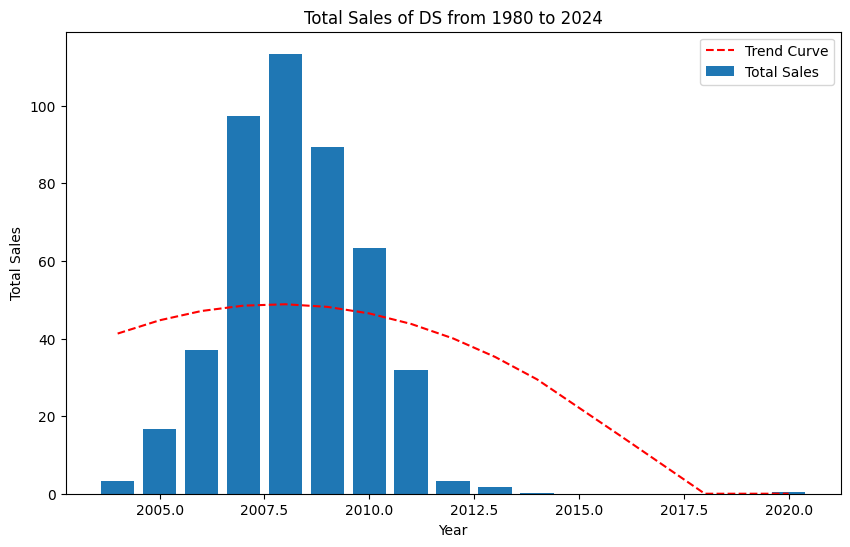

In [16]:
# Example usage:
single_graph((1980, 2024), 'DS')

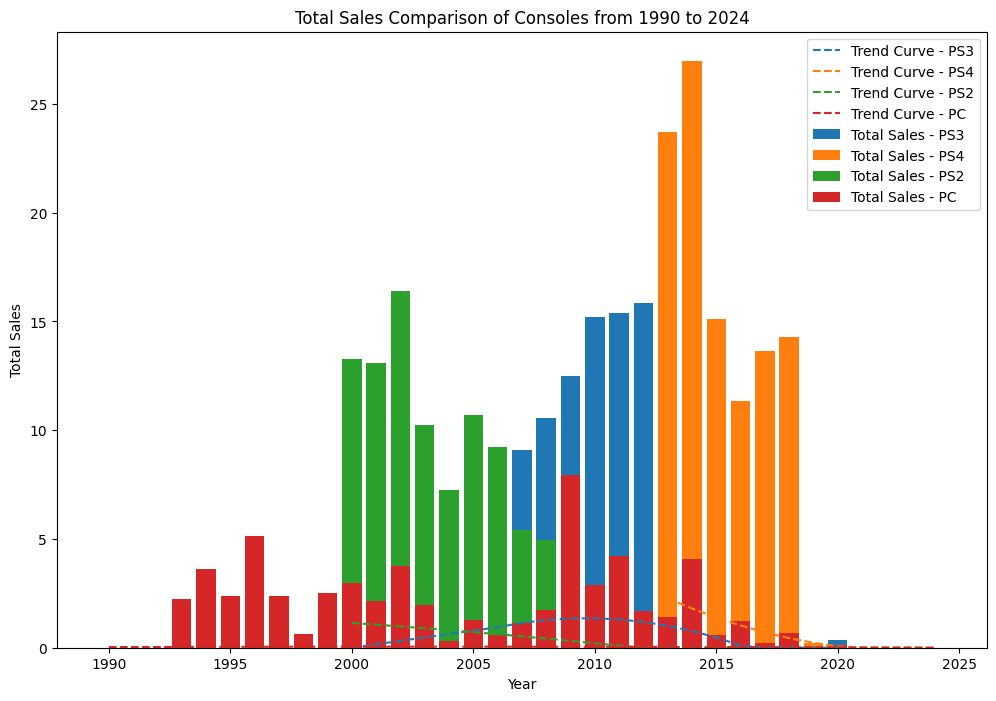

In [17]:
# Example usage:
stacked_graph((1990, 2024), 'PS3', 'PS4', 'PS2', 'PC')

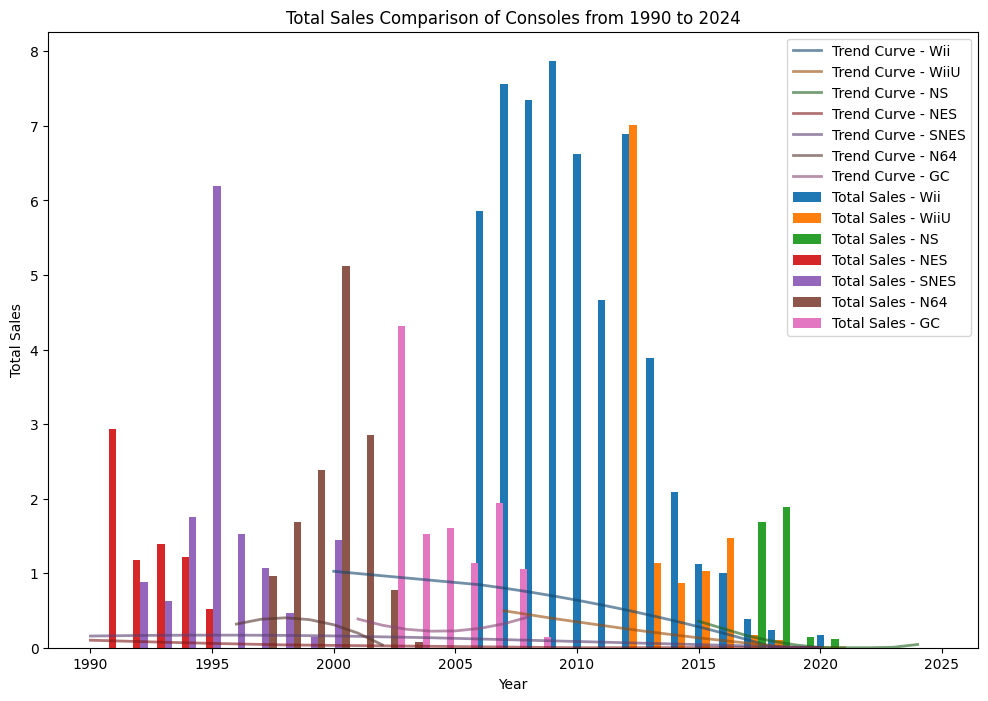

In [18]:
# Example usage:
graph((1990, 2024),  'Wii', 'WiiU', 'NS', 'NES', 'SNES', 'N64', 'GC')

Makes the below markdown table. 

In [19]:
genre_counts = df['genre'].value_counts()

table_markdown = "| Genre | Count |\n|-------|-------|\n"
for genre, count in genre_counts.items():
    table_markdown += f"| {genre} | {count} |\n"


# print(table_markdown)

Genre Dict with game count

| Genre | Count |
|-------|-------|
| Misc | 8932 |
| Action | 7440 |
| Adventure | 5370 |
| Sports | 5341 |
| Role-Playing | 4929 |
| Shooter | 4760 |
| Platform | 3556 |
| Strategy | 3305 |
| Puzzle | 3139 |
| Racing | 3095 |
| Simulation | 2829 |
| Fighting | 2143 |
| Action-Adventure | 1190 |
| Visual Novel | 424 |
| Music | 259 |
| Party | 103 |
| MMO | 92 |
| Board Game | 22 |
| Education | 21 |
| Sandbox | 15 |

In [20]:
top_genre('Action')

,title,total_sales
0,Grand Theft Auto V,20.32
1,Grand Theft Auto V,19.39
2,Grand Theft Auto: Vice City,16.15
3,Grand Theft Auto V,15.86
13,Grand Theft Auto III,13.10
16,Grand Theft Auto IV,11.09
19,Grand Theft Auto IV,10.57
28,Grand Theft Auto V,8.72
35,Grand Theft Auto: Liberty City Stories,7.72
46,Uncharted 2: Among Thieves,6.74


In [21]:
genre_2001

,release_date,genre,total_sales
0,2001,Action,33.45
1,2001,Action-Adventure,0.00
2,2001,Adventure,14.64
3,2001,Education,0.00
4,2001,Fighting,9.47
5,2001,Misc,12.25
6,2001,Party,0.00
7,2001,Platform,20.53
8,2001,Puzzle,8.20
9,2001,Racing,31.08


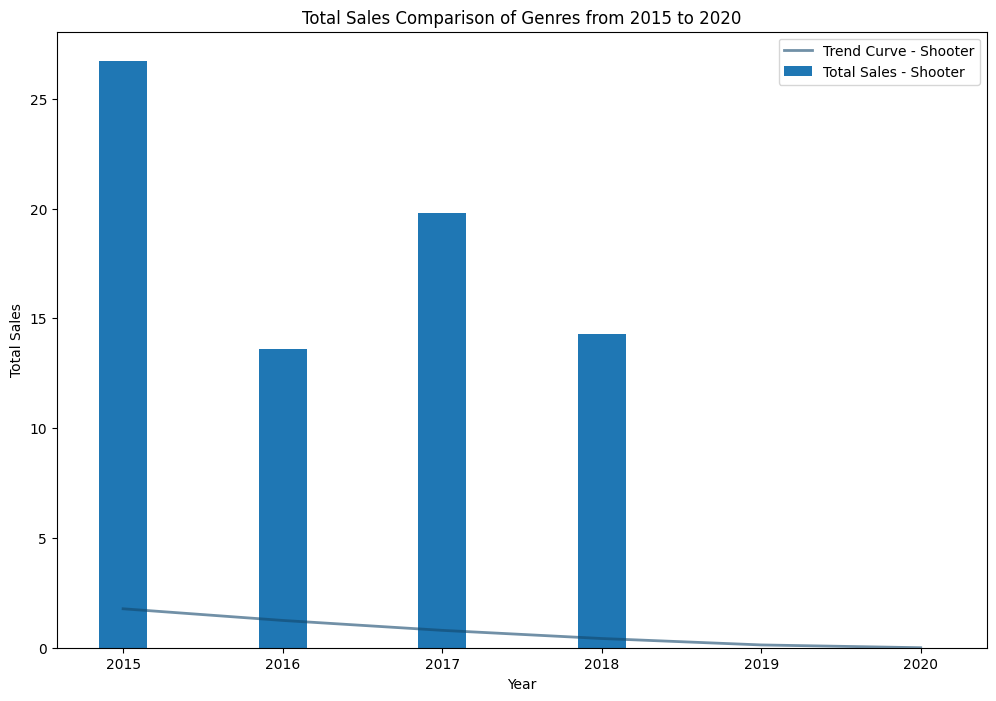

In [22]:
graph_genre((2015,2020), 'Shooter')

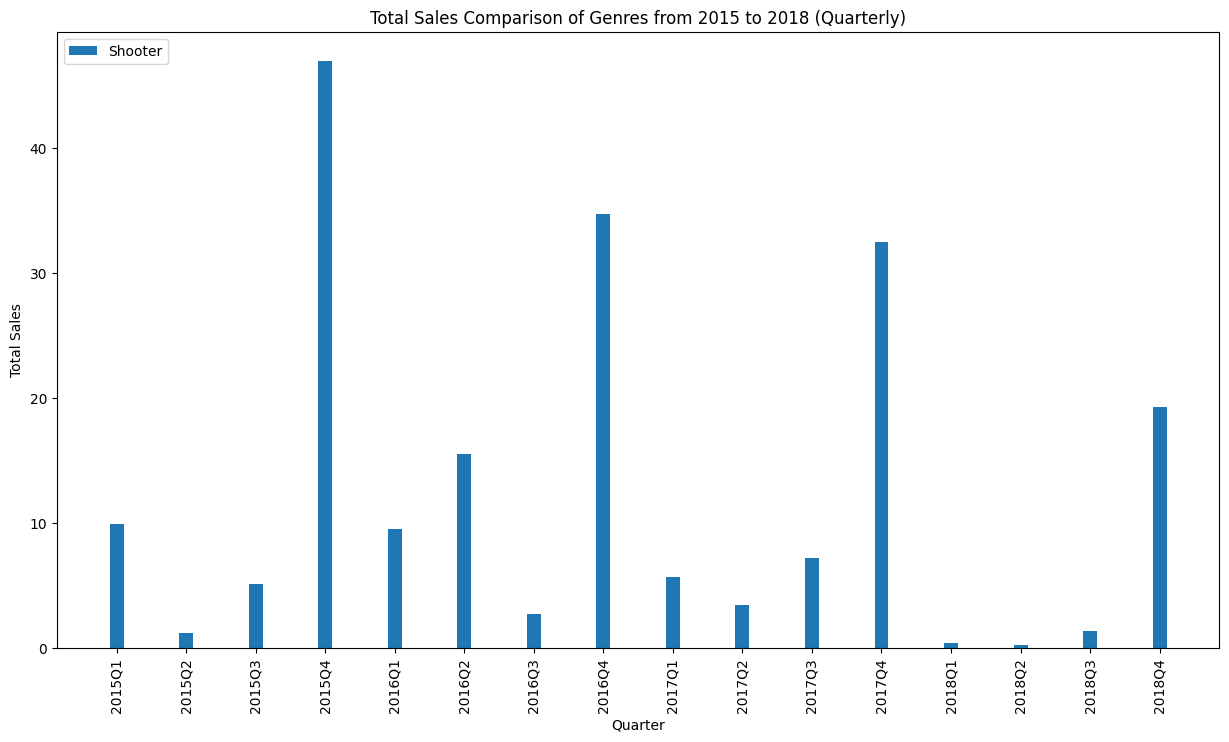

In [23]:
graph_genre_quarterly((2015,2018), 'Shooter')